# Stochastic VI on Probabilistic Count Matrix Factorization

**TODO**: compare the time that Gibbs sampling takes to achieve a certain log-likelihood with CAVI to see who's faster. Then compare with SVI and SGLD.

In [1]:
%matplotlib inline

import sys
sys.path.insert(0, '../')
import utils, cavi, svi, svi_new, cavi_new, gibbs
import plot_utils

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

from scipy.stats import gamma

import operator

plt.style.use('ggplot')

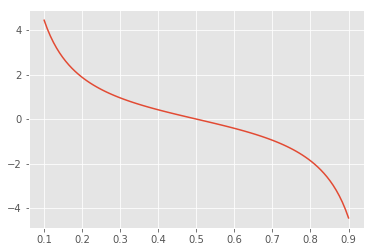

In [2]:
pi = np.linspace(0.1, 0.9, num=100)
p = 0.5
grad = (p - pi) / (pi * (1-pi))

plt.plot(pi, grad)
plt.show()

In [3]:
pi = np.linspace(0, 1, num=100)
f = 4*(pi - 0.5)**2
f_ = 8*pi - 4

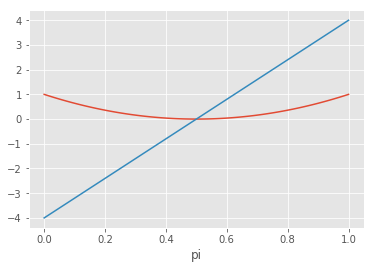

In [4]:
plt.plot(pi, f)
plt.plot(pi, f_)
plt.xlabel('pi')
plt.show()

In [5]:
sol = 0.1
n_it = 10
for it in range(n_it):
    step_size = (it + 1.)**(-0.9)
    grad = 8 * sol - 4
    sol = sol - step_size * grad
    if sol > 1:
        sol = 1.
    elif sol < 0.:
        sol = 0.
    print('Step: {0:.2}\t Grad: {1:.2}\tSol: {2:.2}'.format(step_size, grad, sol))

Step: 1.0	 Grad: -3.2	Sol: 1.0
Step: 0.54	 Grad: 4.0	Sol: 0.0
Step: 0.37	 Grad: -4.0	Sol: 1.0
Step: 0.29	 Grad: 4.0	Sol: 0.0
Step: 0.23	 Grad: -4.0	Sol: 0.94
Step: 0.2	 Grad: 3.5	Sol: 0.24
Step: 0.17	 Grad: -2.1	Sol: 0.6
Step: 0.15	 Grad: 0.81	Sol: 0.48
Step: 0.14	 Grad: -0.19	Sol: 0.5
Step: 0.13	 Grad: 0.02	Sol: 0.5


In [6]:
(0.5 - 0.999)/(0.999 * (1-0.999))

-499.499499499499

In [7]:
pi[np.where(np.abs(grad)<=1.)[0]]

array([0.])

In [8]:
# Experiment parameters
N = 1000 # number of observations
P = 10 # observation space dimensionality
K = 2 # latent space dimensionality
C = 2 # number of clusters

T = 60.
S = 1.

# Generate data set
z_p = 0.5
eps = 5.
Y, D, X, R, V, U, clusters = utils.generate_data(N, P, K, C=C, zero_prob=z_p, 
                                                 eps=eps, return_all=True)

Y_train, Y_test, U_train, U_test, c_train, c_test = train_test_split(Y, U.T, clusters, test_size=0.2, random_state=42)

In [9]:
# Run PCA
pca_U = PCA(n_components=2).fit_transform(Y_train)

# Run Gibbs sampling and get estimates (pCMF)
alpha = np.ones((2, K))
alpha[0, :] = 3.
alpha[1, :] = 0.5
beta = np.ones((2, P, K))
pi = np.ones((P,)) * 0.5
print('Gibbs:')
inf = gibbs.GibbsSampling(Y_train, alpha, beta, pi)
gibbs_ll = inf.run_gibbs(n_iterations=4000, empirical_bayes=True, mc_samples=10, return_ll=True, sampling_rate=S, max_time=T)
gibbs_U = inf.U # Use the last Gibbs sample of U
# gibbs_U = np.mean(U_samples[10:], axis=0) # Use the sample average after the burn-in period

print('\n')

# Run CAVI and get estimates (pCMF)
alpha = np.ones((2, K))
alpha[0, :] = 3.
alpha[1, :] = 0.5
beta = np.ones((2, P, K))
pi = np.ones((P,)) * 0.5
print('CAVI_new:')
inf = cavi_new.CoordinateAscentVI(Y_train, alpha, beta, pi)
cavi_ll = inf.run_cavi(n_iterations=4000, empirical_bayes=True, return_ll=True, sampling_rate=S, max_time=T)
cavi_U = inf.a[0] / inf.a[1] # VI estimate is the mean of the variational approximation

print('\n')

# Run SVI and get estimates (pCMF)
alpha = np.ones((2, K))
alpha[0, :] = 3.
alpha[1, :] = 0.5
beta = np.ones((2, P, K))
pi = np.ones((P,)) * 0.5
print('SVI_new:')
inf = svi_new.StochasticVI(Y_train, alpha, beta, pi)
svi_ll = inf.run_svi(n_iterations=4000, empirical_bayes=True, minibatch_size=100, return_ll=True, sampling_rate=S, max_time=T)
svi_U = inf.a[0] / inf.a[1] # VI estimate is the mean of the variational approximation

Gibbs:
Iteration 9/4000. Log-likelihood: -1.179. Elapsed: 60 seconds

CAVI_new:
Iteration 206/4000. Log-likelihood: -1.062. Elapsed: 60 seconds

SVI_new:


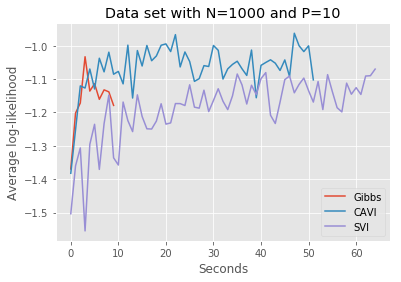

In [10]:
plt.plot(gibbs_ll[1], label='Gibbs')
plt.plot(cavi_ll[1], label='CAVI')
plt.plot(svi_ll[1], label='SVI')
plt.ylabel('Average log-likelihood')
plt.xlabel('Seconds')
plt.title('Data set with N={} and P={}'.format(N, P))
plt.legend()
plt.show()

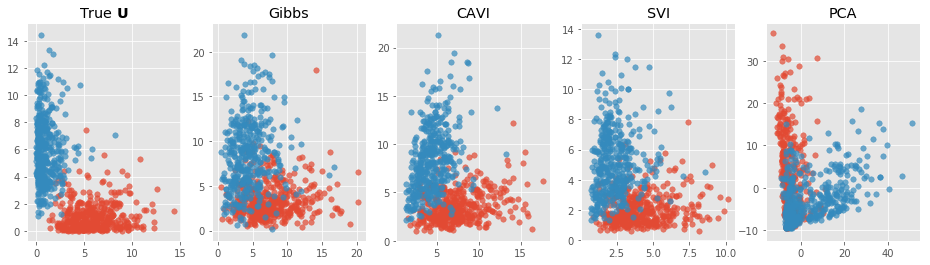

In [11]:
U_list = [U_train, gibbs_U, cavi_U, svi_U, pca_U]
title_list = ['True $\mathbf{U}$', 'Gibbs', 'CAVI', 'SVI', 'PCA']
n_results = len(U_list)

assert len(U_list) == len(title_list)

fig = plt.figure(figsize=(16, 4))

s = 30
alpha = 0.7
labels=None
for i in range(len(U_list)):
    ax = plt.subplot(1, n_results, i+1)
    handlers = []
    for c in range(C):
        h = ax.scatter(U_list[i][c_train==c, 0], U_list[i][c_train==c, 1], s=s, alpha=alpha)
        handlers.append(h)
    if labels is not None:
        ax.legend(handlers, labels, scatterpoints=1)
    plt.title(title_list[i])
plt.show()

In [12]:
true_silh = silhouette_score(U_train, c_train)
gibbs_silh = silhouette_score(gibbs_U, c_train)
cavi_silh = silhouette_score(cavi_U, c_train)
svi_silh = silhouette_score(svi_U, c_train)
pca_silh = silhouette_score(pca_U, c_train)

scores = {'CAVI': cavi_silh, 'Gibbs': gibbs_silh, 'PCA': pca_silh, 'SVI': svi_silh}

sorted_scores = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)

print('Silhouette scores (higher is better):')
print('\033[1m- {0}: {1:.3}\033[0m'.format(sorted_scores[0][0], sorted_scores[0][1]))
for score_tp in sorted_scores[1:]:
    print('- {0}: {1:.3}'.format(score_tp[0], score_tp[1]))
    
print('\nSilhouette of true U:')
print('%0.3f' % true_silh)

Silhouette scores (higher is better):
- CAVI: 0.35
- SVI: 0.334
- Gibbs: 0.279
- PCA: 0.13

Silhouette of true U:
0.573


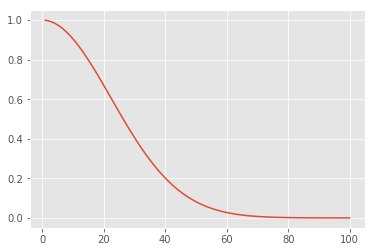

In [16]:
x = np.linspace(1, 100, num=100)
lam = 0.001
probs = np.exp(-lam * x**2)

plt.plot(x, probs)
plt.show()